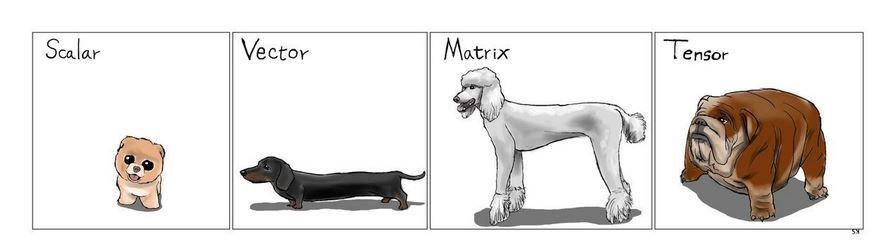

Source: https://www.moshesipper.com/research.html

In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Neural Networks

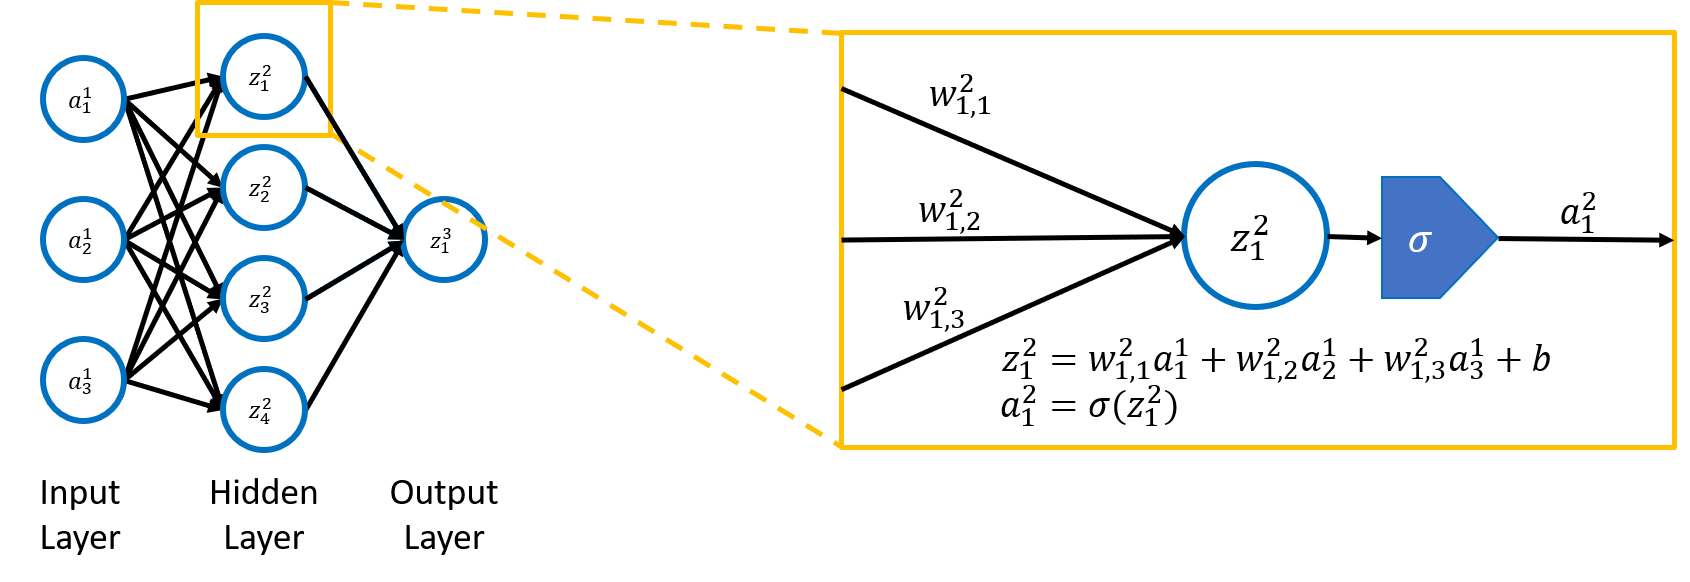

Also known as a multi-layer perceptron (MLP), the neural network is a machine learning model that operates as a function approximator, seeking to map input values to known output values through an iter- ative training process on real data. Estimating the parameters of a neural network model is referred to as “learning” the network.

## Layers



In their simplest form, neural networks consist of an input layer, some number of hidden layers $l \in 1,..,N$ (where $N$ is the number of hidden layers), and an output layer $L$, where each layer contains of some number of nodes, with the input layer having one node per input variable and the output layer containing one node per output value. Within each of the hidden layers, any number of nodes can be used and, in a feed-forward neural network, each node in the hidden layer will be connected to each node in the prior layer.

Theory suggests that an infinitely wide neural network could approximate any function, in practice training such a wide network may require prohibitively many observations. A more common practice is to use fewer nodes in each layer and stack multiple layers depth-wise, allowing for more complex functions to be approximated. 

## Nodes

At each node of a hidden layer, for a standard feed-forward neural network, a weighted sum of all outputs of the previous layers, is learned, such that the predicted output, $z_j^l$, of node $j$ in the $l$th layer is

$$
z_j^l = \sum_k w_{jk}^l a_k^{l-1} + b_j^l
$$

where $k$ are the neurons in the $(l-1)$th layer and $w_{jk}^l$ is the weight for the $j$th node coming from the $k$th node in the $l$th layer. The $b_j^l$ is an optional bias or offset term that is also learned. The term $a_k^{l-1}$ represents the activation of the output of the $k$th node in the $(l-1)$th layer, allowing us to weight prior outputs. This activation arises from necessity as the prior equatons, in its current form, is a linear equation and even if we were to stack these linear layers, we would still only be able to approximate linear functions, therefore, we introduce non-linear activations such that

$$
a_j^l = \sigma\bigg(\sum_k w_{jk}^l a_k^{l-1} + b_j^l\bigg)
$$

where $\sigma$ represents a non-linear function, $\sigma:\mathbb{R}\rightarrow\mathbb{R}$, that maps the output of the current node to a new real value. (Note that in the first hidden layer $z_j^l$ is a weighted sum of the raw input values). Common forms for $\sigma$ are sigmoid functions, hyperbolic tangents, and even partially linear functions like the Rectified Linear Unit (ReLU). Choosing between these options can be very dataset dependent and must often be approached empirically, certain data types and architectures have shown particular effectiveness with a specific activation function.

In [2]:
class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y


class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [3]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


In [4]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(3, activation="softmax")
])

## Loss Function

To define a "deep" neural network for a supervised learning problem, we must decide on the number of layers, the number of nodes in each layer, the choice of activation function, and some way to evaluate the quality of these predicted outputs. For evaluating the outputs, it is common practice to define a loss (or cost) function that quantifies the difference between the predicted and known output in a supervised learning problem. The only constraints on the loss function are that it must be a non-negative differentiable (and ideally convex) function of the weights and biases, as it will need to guide the optimization algorithm in how best to update the weights and biases to improve the quality of predictions. A common loss function for regression problems (i.e. predicting a continuous output value) is the quadratic loss, also known as mean squared error (MSE),

$$
    C(w,b) = \frac{1}{2N}\sum_x \| y(x) - \hat{y}(x) \|^2
$$

where $y(x)$ is the real output, $N$ is the number of training observations, and $\hat{y}(x)$ is the predicted output from the neural network for a given training instance $x$. We sum over all training instances to calculate the total loss. Since the goal of a trained neural network would ideally be to make perfect predictions, we would like the loss to be 0, the minimum of this function, therefore, we will seek to update the weights, $w$, and biases, $b$, so as to minimize the above loss function. Unfortunately, perfect predictions are rarely achievable and often not desirable as it is assumed we are training on data that is randomly sampled from a real population and it is instead more of interest that the neural network generalizes to unseen data from the same population.

It is also critical that the choice of loss function be closely related to the actual measure of quality for the task. This choice is complicated when presented with a task that does not have a naturally differentiable loss function. For example, in a classification task (e.g. classifying images as cats or dogs), we'd ideally use the 0-1 loss, which simply states,

$$
    C(w,b) = I(\hat{y} \neq y)
$$

where $I$ is the indicator function taking the value of 1 when the predicted label does not equal the real label and 0 otherwise. While this is exactly the quantity we'd like to minimize in this binary classification task, the indicator function is not a differentiable function with respect to the weights and biases in the neural network. The optimizer used in neural networks requires a differentiable loss function so in practice, for classification tasks, the cross-entropy loss function, shown in the equation below, is used as it is a strong proxy for the 0-1 loss

$$
    C(w,b) = \frac{1}{N} \sum_x \big[y(x)\log \hat{y}(x) + (1-y(x))\log(1-\hat{y}(x))\big]
$$

where $y(x)$ and $\hat{y}(x)$ are the distributions of probability for the real and predicted outputs respectively. The probability distributions for our real labels will effectively be one-hot encoded vectors (also known as dummy variables) with a one in the position for the true label and zero elsewhere. Since cross-entropy is a measure of the difference between two distributions, minimizing this loss should result in moving the predicted probability distribution towards this true label. It is worth noting that cross-entropy loss is not a perfect proxy for the 0-1 loss and it is possible to minimize the cross-entropy loss but not improve the accuracy of the predicted labels.

<img src='https://d3i71xaburhd42.cloudfront.net/6baca6351dc55baac44f0416e74a7e0ba2bfd03e/1-Figure1-1.png'>

Source: "Visualizing the Loss Landscapes of Neural Nets", Li et al. 2018


In [5]:
model.compile(optimizer="SGD",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## Backpropagation

With underlying ideas introduced as early as the 1960's and explicitly stated in reference to neural networks in the 1980's, backpropagation is an algorithm that allows for the efficient and effective training of neural networks by computing the gradient of the loss function with respect to all of the parameters in the model. The parameter update step is as simple as moving in the direction of steepest descent, though more complicated approaches are typically necessary for effective training.

The term backpropagation directly implies how the calculation of errors proceeds in neural networks in that we begin at the output layer and propagate the error backwards through the model, updating parameters along the way. To this end, the first relevant equation is that of the error in the output layer

$$
    \delta_j^L = \frac{\partial C}{\partial a_j^L} \sigma'(z_j^L)
$$

where $\delta_j^L$ represents the error in the $j$th node of the output layer $L$. After a single forward-pass of training (i.e. passing in a training instance as input and producing a final output prediction), the loss can be calculated. Using the loss function, we can calculate the rate of change for the loss with respect to the output activation at the $j$th node, $\partial C / \partial a_j^L$. The derivative of the cost function with respect to the output activation for the $j$th node in the output layer gives a measure of the rate of change for the cost function. Extending the equation above to all nodes in the output layer, we can represent this as a matrix-based equation, allowing this calculation to be easily parallelized

$$
    \delta^L = \nabla_a C \odot \sigma'(z^L).
$$

Once we have the error in the output layer, we can use backpropagation to calculate the error in every other layer successively

$$
    \delta^l = ((w^{l+1})^\top \delta^{l+1})\odot \sigma'(z^l)
$$

beginning with the layer just prior to the output layer, $\delta^l = \delta^{L-1}$, making $\delta^{l+1}$ simply equal $\delta^L$. This will be multiplied by the transpose of the weight matrix at layer $L$, effectively propagating the error through these weights and then performing element-wise multiplication with the second term, to pass this error through the activation function giving an estimate of the error at the input to layer $L-1$. This then provides the values necessary to calculate the error at layer $L-2$ and so on until the input layer is reached.

Using these estimates of error at the layers, we can simply calculate the rate of change of the loss function with respect to the bias terms as

$$
    \frac{\partial C}{\partial b_j^l} = \delta_j^l.
$$

Similarly, we can calculate the rate of change of the loss with respect to any weight in the network as

$$
    \frac{\partial C}{\partial w_{jk}^l} = a_k^{l-1} \delta_j^l.
$$

That is the rate of change for a specific weight depends on the product of the output activation of the prior layer and the error at the relevant node for the current layer.

Through backpropagation, specifically the prior two equations, we can compute the gradient of the loss function with respect to all parameters in the neural network in a single forward and backwards pass of the model.

# Examples

## Binary Classification of Movie Reviews

In [5]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

17473536/17464789 [==============================] - 0s 0us/step


In [6]:
# Decoding review back to text

word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])
print(train_data[0])
decoded_review

1654784/1641221 [==============================] - 0s 0us/step
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 3

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [7]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
y_train = nbp.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [10]:
y_train[0]

1.0

In [11]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [12]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [15]:
!nvidia-smi

Wed Mar 16 15:56:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    76W / 149W |   2244MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 46ms/step - loss: 0.5176 - accuracy: 0.7869 - val_loss: 0.4236 - val_accuracy: 0.8371
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.3135 - accuracy: 0.8995 - val_loss: 0.3275 - val_accuracy: 0.8719
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.2244 - accuracy: 0.9253 - val_loss: 0.2862 - val_accuracy: 0.8872
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1738 - accuracy: 0.9434 - val_loss: 0.2756 - val_accuracy: 0.8877
Epoch 5/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1427 - accuracy: 0.9556 - val_loss: 0.2843 - val_accuracy: 0.8850
Epoch 6/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1178 - accuracy: 0.9634 - val_loss: 0.3173 - val_accuracy: 0.8795
Epoch 7/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0996 - accuracy: 0.9720 - val_loss: 0.3428 - val_accuracy: 0.8755
Epoch 8/20
30

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


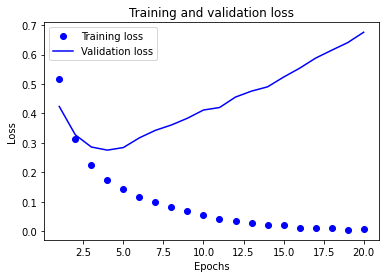

In [16]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

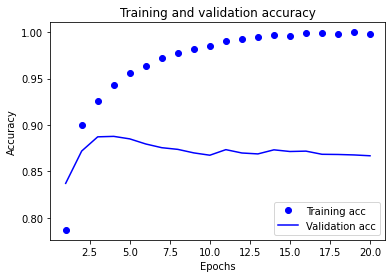

In [17]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [18]:
model.predict(x_test)

array([[0.00738818],
       [0.9999994 ],
       [0.95326185],
       ...,
       [0.00412759],
       [0.00652977],
       [0.9004446 ]], dtype=float32)

## Multiclass Classification: Classifying News Topics

In [19]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2121728/2110848 [==============================] - 0s 0us/step


In [20]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [21]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [22]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [23]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [24]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [25]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 32ms/step - loss: 2.5676 - accuracy: 0.4620 - val_loss: 1.7115 - val_accuracy: 0.6350
Epoch 2/20
16/16 [==============================] - 0s 17ms/step - loss: 1.4219 - accuracy: 0.6991 - val_loss: 1.3377 - val_accuracy: 0.7190
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 1.0753 - accuracy: 0.7691 - val_loss: 1.1672 - val_accuracy: 0.7390
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8521 - accuracy: 0.8201 - val_loss: 1.0756 - val_accuracy: 0.7790
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - loss: 0.6881 - accuracy: 0.8550 - val_loss: 0.9829 - val_accuracy: 0.7890
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.5544 - accuracy: 0.8827 - val_loss: 0.9765 - val_accuracy: 0.7910
Epoch 7/20
16/16 [==============================] - 0s 17ms/step - loss: 0.4499 - accuracy: 0.9064 - val_loss: 0.9494 - val_accuracy: 0.7890
Epoch 8/20
16

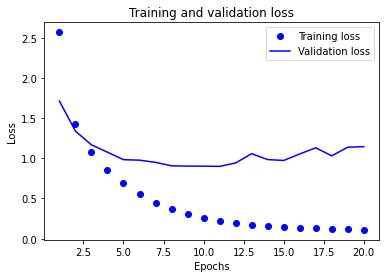

In [26]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

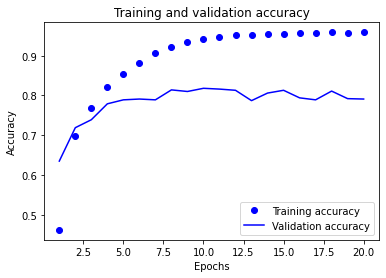

In [27]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [28]:
from collections import Counter
Counter(test_labels)

Counter({0: 12,
         1: 105,
         2: 20,
         3: 813,
         4: 474,
         5: 5,
         6: 14,
         7: 3,
         8: 38,
         9: 25,
         10: 30,
         11: 83,
         12: 13,
         13: 37,
         14: 2,
         15: 9,
         16: 99,
         17: 12,
         18: 20,
         19: 133,
         20: 70,
         21: 27,
         22: 7,
         23: 12,
         24: 19,
         25: 31,
         26: 8,
         27: 4,
         28: 10,
         29: 4,
         30: 12,
         31: 13,
         32: 10,
         33: 5,
         34: 7,
         35: 6,
         36: 11,
         37: 2,
         38: 3,
         39: 5,
         40: 10,
         41: 8,
         42: 3,
         43: 6,
         44: 5,
         45: 1})

In [28]:
813/len(test_labels)

0.3619768477292965

# Convolutional Neural Networks

Feed-forward neural networks, as discussed in the previous section, provide a flexible framework for adapting to many different data types in supervised learning problems. For most structured (i.e. rectangular) datasets it is straightforward to construct an appropriate neural network, as the number of input nodes would equal the number of variables in the dataset. Consider an alternate data structure such as images where the choice of input layer becomes less obvious. Arguably, the most natural approach would be to take an image and flatten it into a single vector, such that each pixel represents its own variable and, therefore, its own node. Given enough training data, it is not unreasonable for this model to learn the spatial relationships between pixels, however, how much data is "enough" is difficult if not impossible to do a priori. Further, the computational resources, in both time and memory, necessary to train this model can quickly exceed the limits of modern computers. 

For example, given a classification task for a set of RGB images of dimension 400x400x3 (height x width x channel), the input layer alone would have 480,000 nodes, as there is one node per pixel. Even if the first hidden layer were to bottleneck this information dramatically into say 1000 nodes, there would still be 48 million weights that need to be learned in the first layer alone. For context, some modern image classification models have achieved near state-of-the-art results with only a fraction of the number parameters as our proposed feed-forward architecture.

The ability of these modern neural network architectures to achieve groundbreaking results with a fraction of the computational resources can almost entirely be contributed to one method, the convolutional neural network (CNN). The CNN directly exploits our inductive bias that, in sequential or spatial data, we should expect data near to each other to be related and through these local relationships, potentially form some larger structure. This seems quite obvious for images, where pixels near to each other probably form some structure or feature and these local features combine together to form an image, but it even extends to less obvious domains such as time-series analysis where local patterns may explain effects on a shorter time-scale (e.g. a week) and they combine together to define the effects over a larger time-scale (e.g. a season).

Even more critical is that a feed-forward neural network would not be invariant to translation of images. Since the pixels themselves are the features, if the object being classified was in the bottom-right corner of all of the training images but moved to the top-left in the test images (not unrealistic in a real dataset), the model would have never learned the relevant features for this region of pixel space. This effect is exacerbated when you consider the multitude of augmentations, that would not change the label of the subject: rotation, translation, zooming, etc. As we will see in the following sections, the CNN naturally handles this issue as well, further supporting its effectiveness for image data.

The main building block of the CNN is the convolution operation itself. A convolution operation is the integral of the product of two functions as one is shifted across the other. Mathematically, given two continuous functions $x$ and $w$ the convolution of $x$ and $w$ over the time $t$ can be written as

$$
    (x*w)(t) = \int_{-\infty}^{\infty} x(\tau)w(t-\tau)\, d\tau
$$
where $x*t$ denotes the convolution operation. Another way to think about the convolution is that $w(t)$ is a weighting function across the domain of $t$ and is therefore forming a weighted average of $x$ at every position in time. Transferring this concept to CNNs, we can think of $x$ as the input values (e.g. images) and $w$ will be the learnable kernels. The kernels will be convolved with the image by moving across the whole image as a sliding window, forming new representations of the image as they go. This is a discrete form of the convolution operation shown above, that multiplies the image patch by the kernel. If we have a one channel image (i.e. gray-scale) then the convolution operation can be written as a double sum across the two image dimensions

$$
    (x*w)(i,j) = \sum_m \sum_n w(i+m, j+n)\, x(m,n)
$$

where $m$ and $n$ represent the height and width of the image. The figure below shows how this convolution operation between the kernel and image appears visually. We can see that, beginning in the top left of the image, the dot product of the image patch covered by the kernel and the kernel itself will provide the output value in the new representation of the image. The kernel will then systematically slide across the window repeating this multiplication with the underlying image patch at each step. The choice of how far the kernel slides each time is a hyperparameter of the CNN, referred to as the stride. 

<img src='https://drive.google.com/uc?id=1rfCMbUIIMQXE7Dx-vfsmRSk8z3Eh_0Eu'>

At this point, the values in the kernel have been viewed as fixed and in fact many common kernels exist with known values, such as the kernels for the identity function, blurring, and sharpening shown in the figure below. The fact that the kernels are learned is one of the distinguishing characteristic in CNNs, where the weights or values in the kernel are analogous to the weights between nodes in feed-forward neural networks. From a calculation standpoint, these weights are learned in the exact same way as well since they are simply matrix operations and can therefore be learned through backpropagation.

Focusing still on the first layer of the CNN, where the input image is convolved with a single kernel, we can see that in the event that the kernel operates entirely within the bounds of the image, the output representation known as a feature map will be smaller than the original input, referred to as a "valid" convolution. This can sometimes be a desirable property as it means any subsequent convolutions on the feature map will require fewer operations and therefore less memory and computational time. If it is of interest to retain the dimensions of the input zero-padding is a common practice where by zero values are added around the edges of the original image, so that the trimmed feature map matches the dimensions of the original image (prior to zero-padding). There are also typically dozens of kernels learned within a layer, each with a random initialization, allowing for a variety of feature maps to be formed. The number of kernels as well as the size of the kernel are also hyperparameters of the model and the product of those two values will provide the number of weights to be learned in that layer.

<img src='https://drive.google.com/uc?id=11mnc_lrY5HNWdh0-mzRlOn68-lEPYB1_'>


Once these feature maps are formed, we can add another convolutional layer, which convolves a new set of kernels with these outputs forming a new set feature maps. This hierarchical structure seems to be one of the strengths of CNNs as subsequent layers can learn different hierarchies of representations of the input images. An example of this is shown in the figure below, where early layers appear to be learning common features like edges and contrast regions, while later layers combine these lower-level features to form more logical structures that would identify the object.

This hierarchical approach using sliding kernels solves many of the problems present from using feed-forward neural networks for these types of tasks as these feature maps learn translation and often scale-invariant features of an input image. The CNN also dramatically reduces the computational resources by effectively sharing weights across the entire image by sliding the kernels, in contrast to the feed-forward neural network connecting every input node to every node in the next layer. For example, consider a somewhat standard layer choice of having 16 3x3 kernels. This layer would have a total of $(3*3)*16=144$ weights in it compared to the example above with the single feed-forward layer that contained 48 million weights. As we will see later, there are plenty of examples of the CNN outperforming a feed-forward neural network even with (and possibly because of) this reduced model capacity. 

<img src='https://drive.google.com/uc?id=1ScRy8cUKWuLzzqSpZbTeP5fGP07WQKWr'>

The convolution operation alone was not enough to achieve strong results on image recognition tasks, however, when paired with a few other critical architecture choices, it quickly surpassed existing state-of-the-art techniques and holds the lead today.

## Pooling Layers and Activation Functions

Just as with feed-forward neural network layers, CNN layers are also often followed by a non-linear activation layer. These activation functions operate identically in the CNN so the same functions are used: sigmoid, hyperbolic tangent, and more commonly the Rectified Linear Unit (ReLU). The ReLU that has shown much empirical success as an activation function for convolutional layers and is therefore widely used, at least as an initial choice. Given the output of a convolutional layer $z$, the functional form of the ReLU is

$$
    f(z)=\max(0,z).
$$

One of the main advantages of the ReLU, aside from its empirical effectiveness, is the reduction in computational resources since, by construction, it can form sparse activations across a network as any negative outputs will simply be set to 0. For a randomly initialized layer, sampled from a distribution that is symmetric about 0, we would expect about 50\% of the activation outputs to be 0 by using the ReLU. It also helps to alleviate the vanishing gradient problem that is often present in saturated sigmoid activations but it can still experience the exploding gradient given that it is unbounded in one direction.

After the convolutional layer and ReLU activation, the final component of what has often been referred to as a convolutional block, is a pooling layer. The main motivation behind pooling is similar to some of the other architectural choices made so far in that it seeks to reduce the number of weights necessary in the model. It does this in a way similar to the convolution operation in that it forms a window, smaller than the feature map upon which it is operating, and slides along the feature map, pooling values along the way. The two most common pooling operations are max and average pooling, with max pooling showing greater success in practice. As an example, consider the feature map in the figure below. The max pooling layer shown has two hyperparameters, the size (2x2 here) and the stride (2). Beginning in one corner, the max pooling filter will take the maximum value of the values in the feature map it covers before striding the pre-determined amount and repeating the pooling. The resulting feature map has been shrunk by a factor of two meaning the next convolutional layer will have even fewer weights to be learned. Average pooling operates similarly to max pooling except that at each step, all of the values in the feature map covered by the pooling window will be averaged together. The choice of pooling operation is yet another hyperparameter for the CNN. 

<img src='https://drive.google.com/uc?id=1igGnw-hJRVIUMp_QX7wrsfx2dW8JJ1rB'>

It is common practice to stack these convolutional blocks many times, with each block having as many or more kernels as the prior layers with the final layers having many small feature maps as output. This is another benefit of the pooling layer in that in the final layers, there are many small abstracted representations of the original image in those feature maps. By flattening these final feature maps into a single vector and passing them through a small feed-forward neural network, some combination of the feature maps can be learned to represent the objects of interest. An example of this full architecture is shown in the figure below.

<img src='https://drive.google.com/uc?id=1zcZ0i2Q0cRRvtU7xy2UIv5DpO-70aJVP'>


In [29]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28,28, 1))
x = layers.Flatten()(inputs)
x = layers.Dense(units=256, activation='sigmoid')(x)
x = layers.Dense(units=128, activation='sigmoid')(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 4s 4ms/step - loss: 0.4456 - accuracy: 0.8789
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1925 - accuracy: 0.9428
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1390 - accuracy: 0.9581
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1077 - accuracy: 0.9667
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0866 - accuracy: 0.9740


In [31]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0950 - accuracy: 0.9699
Test accuracy: 0.970


In [32]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         7385

In [33]:
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 17s 9ms/step - loss: 0.1506 - accuracy: 0.9536
Epoch 2/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0433 - accuracy: 0.9865
Epoch 3/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0294 - accuracy: 0.9912
Epoch 4/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0222 - accuracy: 0.9933
Epoch 5/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0174 - accuracy: 0.9947


In [34]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.0307 - accuracy: 0.9898
Test accuracy: 0.990


## Transfer Learning

Transfer learning, in reference to neural networks, has existed for almost half a century with the work of Bozinovski and Fulgosi in 1976 providing both a mathematical model and geometric interpretation of the idea. In Deep Learning, by Goodfellow et al., they define transfer learning, and the related field of domain adaptation, as "the situation where what has been learned in one setting is exploited to improve generalization in another setting". CNNs happen to provide one of the most natural platforms for this approach as well since it is well understood that earlier convolutional layers learn somewhat generic features, that are ubiquitous to many tasks, such as edge detectors. In later layers the model begins to aggregate many of the lower level features into more specific structures relevant to the task upon which it is trained so that the final layer can make a prediction.

Many approaches have shown success in using transfer learning to effectively pre-train (or use an existing pre-trained model) to reduce the amount of training data necessary for their task. For applications where the target task and data are similar to the task and data of the pre-trained model, referred to as the source, often little if any of the layers need to be retrained and instead the "head", the final classification layers can be removed and replaced with layers appropriate for the target task. The weights of the earlier layers are frozen and the model operates as a feature extractor. To that end, it is common to pass all images through the model in advance and extract the final pooled output vector as the new representation of the image. For example, given the task of classifying a relatively small dataset of images of the Greater Swiss Mountain dog vs the Bernese Mountain dog, both of which are classes in ImageNet, it would be appropriate to simply remove the final 1000 node classification layer from a ResNet model pre-trained on ImageNet and pass each image in the new training dataset through the model in one forward pass to extract the feature vectors. The dimensionality of ResNet-50's final pooling layer is 2048, so, for the classification task, a small feed-forward neural network could be constructed with few, if any, hidden layers and a final output layer of a single node layer to perform binary classification of one class vs the other. Alternatively, if the target task differs heavily from the source task, as is common with specialized datasets such as medical or satellite imagery, it is more appropriate to retrain the model with only a few of the early layers' weights frozen since most images, even if they are not the natural images, share low-level features with the images from ImageNet.


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sharadkj","key":"c735d8d431c0b7fec0415b17cfbd2ceb"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dogs-vs-cats

 98% 793M/812M [00:04<00:00, 202MB/s]
100% 812M/812M [00:04<00:00, 203MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 20s 126ms/step - loss: 0.7619 - accuracy: 0.5155 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 7s 113ms/step - loss: 0.7086 - accuracy: 0.5230 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 8s 121ms/step - loss: 0.7073 - accuracy: 0.5660 - val_loss: 0.6608 - val_accuracy: 0.6030
Epoch 4/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6523 - accuracy: 0.6485 - val_loss: 0.6195 - val_accuracy: 0.6430
Epoch 5/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6057 - accuracy: 0.6945 - val_loss: 0.5983 - val_accuracy: 0.6740
Epoch 6/30
63/63 [==============================] - 7s 113ms/step - loss: 0.5744 - accuracy: 0.7095 - val_loss: 1.3603 - val_accuracy: 0.5490
Epoch 7/30
63/63 [==============================] - 8s 115ms/step - loss: 0.5526 - accuracy: 0.7275 - val_loss: 0.8166 - val_accuracy: 0.5820
Epoch

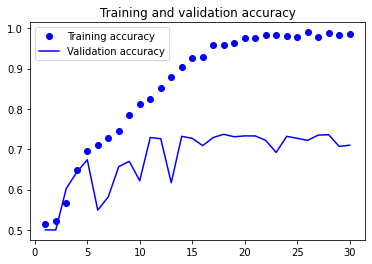

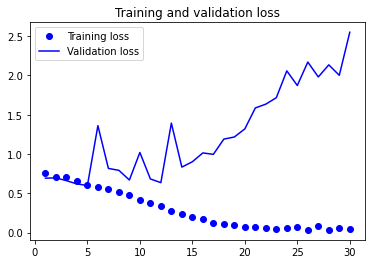

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 53ms/step - loss: 0.6155 - accuracy: 0.6795
Test accuracy: 0.679


In [15]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 2s 0us/step


In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [17]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [18]:
train_features.shape

(2000, 5, 5, 512)

In [19]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 14ms/step - loss: 18.8268 - accuracy: 0.9155 - val_loss: 4.1587 - val_accuracy: 0.9660
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 3.1718 - accuracy: 0.9800 - val_loss: 4.3986 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 2.1847 - accuracy: 0.9815 - val_loss: 4.6089 - val_accuracy: 0.9740
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.7236 - accuracy: 0.9875 - val_loss: 5.0535 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 1.7609 - accuracy: 0.9895 - val_loss: 3.5202 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 1s 12ms/step - loss: 0.7486 - accuracy: 0.9945 - val_loss: 3.3932 - val_accuracy: 0.9820
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.1519 - accuracy: 0.9975 - val_loss: 6.4214 - val_accuracy: 0.9690
Epoch 8/20
6

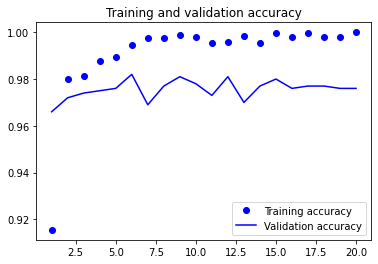

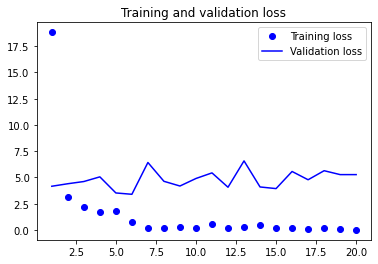

In [20]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()